# EigenCAM alkalmazása YOLOv5 modellre






Első lépésként felcsatoltam a Google Drive-ot, mivel az általam használt betanított modelleket ott tárolom, valamint a vizsgált képeket is a Google Drive-on keresztül érem el. Majd a függőségeket telepítem.


In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/yolo_heatmap_example

/content/drive/MyDrive/yolo_heatmap_example


In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=dacb219fdc2af1dc6f10e7ac17ba4ecb32b24bd7ead0cbd8c71f10ebefe21065
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam


A betanított modellt betöltjük, majd az általa végzett objektumdetektálást megjelenítjük.

YOLOv5 🚀 v7.0-117-g85f6019 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20856975 parameters, 0 gradients
Adding AutoShape... 


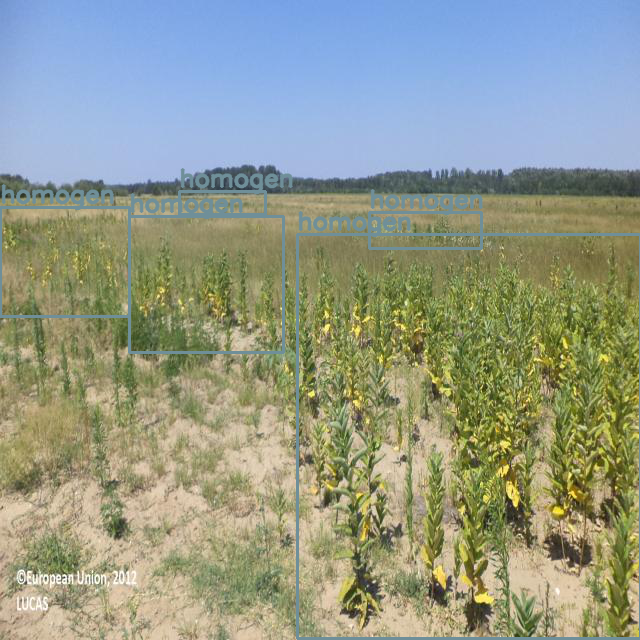

In [44]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img
# no deection
#image_url ="/content/drive/MyDrive/Colab_Notebooks/asclepias/yolov5_train96/yolov5/asclepias_v96_4-1/test/images/2012_49882610E_V_jpg.rf.a02148cdc8f795250a0544719ae7fa3f.jpg"
#image_url ="/content/drive/MyDrive/Colab_Notebooks/asclepias/yolov5_train96/yolov5/asclepias_v96_4-1/test/images/2012_50462608W_V_jpg.rf.da2d9022b17278192b5536a812735960.jpg"
#image_url ="/content/drive/MyDrive/Colab_Notebooks/asclepias/yolov5_train96/yolov5/asclepias_v96_4-1/test/images/2012_50462608S_V_jpg.rf.b260d16fc2f08f8fa0136e381f4483c4.jpg"

#image_url="/content/drive/MyDrive/Colab_Notebooks/asclepias/yolov5_train96/yolov5/asclepias_v96_4-1/test/images/2012_50582740E_V_jpg.rf.008019b3bae419f1aaa2b5bd14194e22.jpg"
#image_url="/content/drive/MyDrive/Colab_Notebooks/asclepias/yolov5_train96/yolov5/asclepias_v96_4-1/test/images/2012_50142760W_V_jpg.rf.01771cd35c229a80483eea65a5d23804.jpg"
##mage_url="/content/drive/MyDrive/Colab_Notebooks/asclepias/yolov5_train96/yolov5/asclepias_v96_4-1/test/images/2012_49962648N_V_jpg.rf.575bf813920326112c417e4392c6b7b0.jpg"
#detection
#image_url ="/content/drive/MyDrive/Colab_Notebooks/asclepias/yolov5_train96/yolov5/asclepias_v96_4-1/test/images/2012_50502706N_V_jpg.rf.7da761514a1ec4c91a970bcffb41888f.jpg"
#image_url ="/content/drive/MyDrive/Colab_Notebooks/asclepias/yolov5_train96/yolov5/asclepias_v96_4-1/test/images/2012_50522632P_V_jpg.rf.4d183bbd34c2b154d769470b870bda4b.jpg"
image_url ="/content/drive/MyDrive/Colab_Notebooks/asclepias/yolov5_train96/yolov5/asclepias_v96_4-1/test/images/2012_50602628N_V_jpg.rf.359e22c558b8f4685100f58d98b1157e.jpg"

img = np.array(Image.open(image_url))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

#model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
path = '/content/drive/MyDrive/Colab_Notebooks/asclepias/yolov5_train96/yolov5'
model = torch.hub.load(path, 'custom', '/content/drive/MyDrive/Colab_Notebooks/asclepias/yolov5_train96/yolov5/runs/train/train_96_modelM/weights/best.pt', source='local')
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]
#print(target_layers)

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

Most létrehozzuk a CAM-modellünket, és futtatjuk a képen:

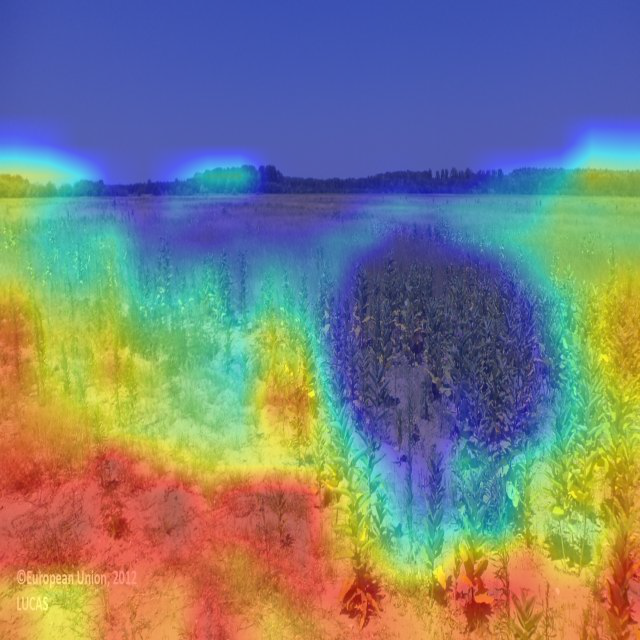

In [45]:
cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

A hőtérképet eltávvolítjuk a képről, majd a befoglaló téglalapokon belül is elvégezzük az aktiváció kimutatását:


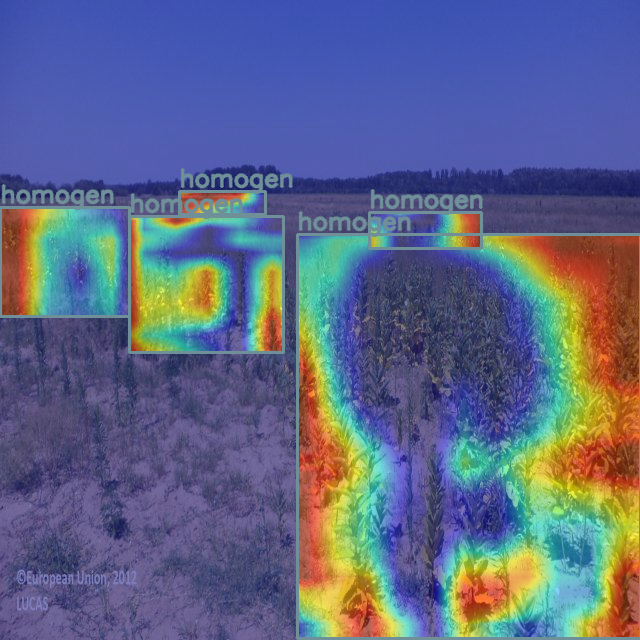

In [46]:
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes


renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(renormalized_cam_image)

Végül mind a 3 képet megjelenítsük egymás mellet:

In [47]:
Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))

Output hidden; open in https://colab.research.google.com to view.

# Beadandó leírása


## Motiváció

A diplomamunkám témája selyemkóró felismerés a YOLOv5 és YOLOv7 objektumfelismerő módszerekkel. Mind a két esetben sikerült elég jó eredményt elérnem az mAP@0.5 kb 90%-os lett a legjobb modell tekintetében. A YOLO technika hajlamos sajnos a kisebb objektumokat nem megtalálni (2 osztálycímkém van, 1db és homogen), ezért úgy gondoltam, hogy érdemesebb lehet a a szóló egyedek helyett (1db) a nagyobb területet lefedő homogén területeket megvizsgálnom abban a tekintetben, ahol nem sikerült detektálni azt az osztályt

## Módszertan

Ahogy említettem a YOLOv5 és v7 objektumdetektálókkal dolgoztam, 2 adathalmazon, a különbség egyrészt a tanítóadatok száma, másrészt az augmentáció fajtái. A két adathalmazban megegyezett a dev és a test halmaz, mind a kettő 221 db képet tartalamzott, amleyeken nem alkalmaztam semmilyen transzformációt a kép átméretezésen és az autoorientáción kívül. 

### A kisebb adathalmaz:
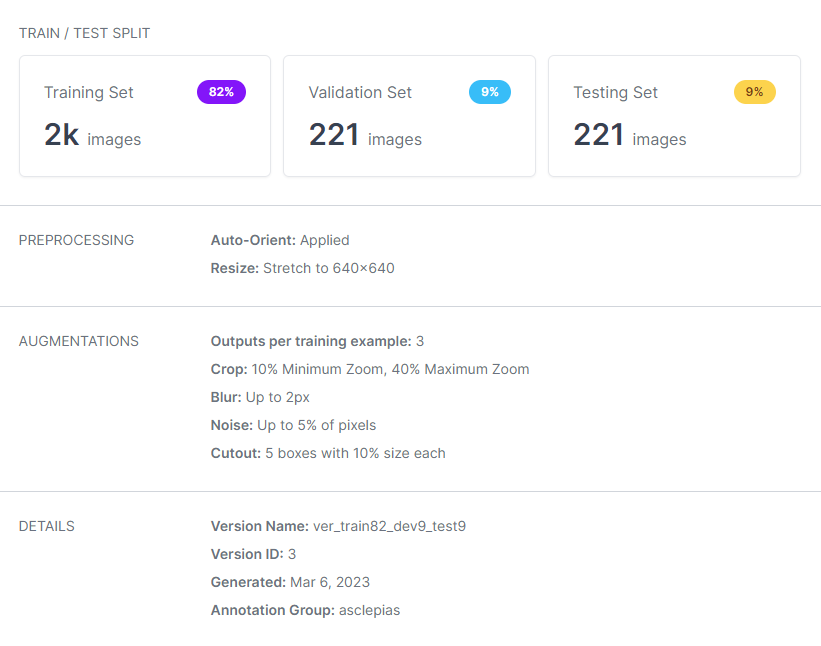

 ### A nagyobb adathalmaz:
 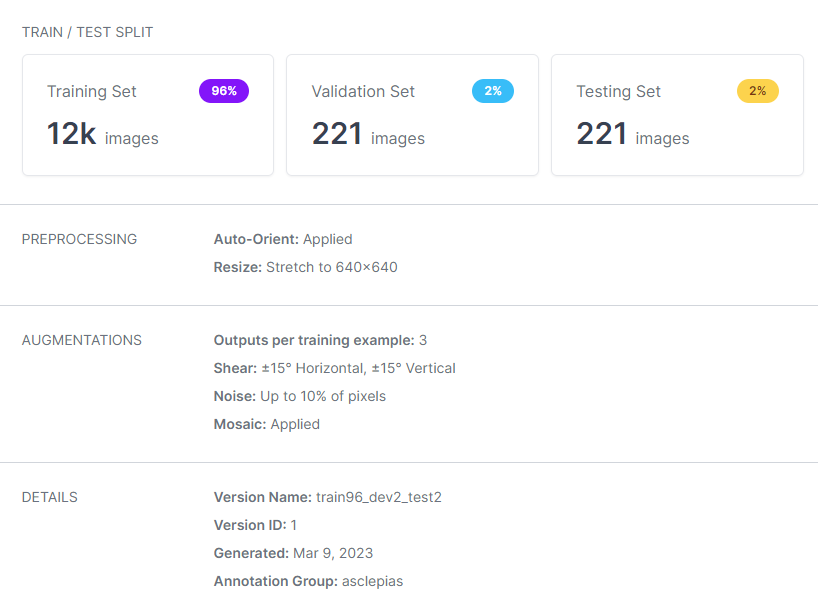



Mindkét adathalmazon tanítottam be modelleket, de a nagyobb bizonyult hatásosabbank, majd a nagyobbon a YOLOv5 közepes méretű (kb 20 millió paraméter) előállt a legjobban teljesítő modell. 
A legjobban teljesítő modellen alkamlaztam az EigenCAM módszert, amely egy gradiensmentes("Gradient Free Methods") metódus.



## Alkalmazott eljárások
### EigenCAM
Az EigenCAM módszer nem használ gradienseket, ezért gyors és univerzálisan alkalmazható, az aktiválások első alapkomponensét adja vissza, és ez legtöbbször a domináns objektumnak felel meg. A gyakori eset az, hogy a határoló dobozon belül egyetlen objektumot észlel

### YOLOv5
A YOLO családba tartozó objektumdetektálásra, osztályozásra, segmentálásra alkalmas keretrendszer. A feladatra egy közepes méretű architektúrát alkalmaztam, 16 epoch és 100 batch méretre, az input kép leskálázásra került 640x640-es méretre, valójában ezek az alapértelmezett beállitásai a módszernek, a többi hiperparamétert sem bántottam és optimalizálás sem történt

### Adathalmaz
A bemutatott modellt a nagyobb adathalmazon tanítottam, amelyen különböző augmentációkat hajtottam végre (3 féle színeltolás, Gauss zaj és CutOut), majd ezeken további augmentálásokat eszközöltem a fönt leírtak szerint (elforgatás, só bors zaj és mosaikba rendezhetőséget engedéjeztem)


## Konklúzióa
Az EigenCAM azt adja vissza, hogy a hálónak hol volt nagy az aktivációja és ez legtöbbször a domináns objektumnak felel meg. Mivel az én esetemben sok zöld terület található, ezért nehéz megmondani, hogy melyek az egybe tartozó részek és a hálónak nehéz dolga van. Sajnos a jól detektált képek esetében sem tudunk biztosat mondani, mivel az aktiváció ott sem csak azokban a régiókban van, ahol a selyemkóró.
Vannak olan esetek, amikor az

Az elvárt eredmény az volna, hogy a bementei képen ott mutatkozik nagyjából magas aktiváció, ahol a képen a befoglaló téglalap található, vagyis a selyemkórónak az elhelyezkedésében. Egy helyes heatmap:
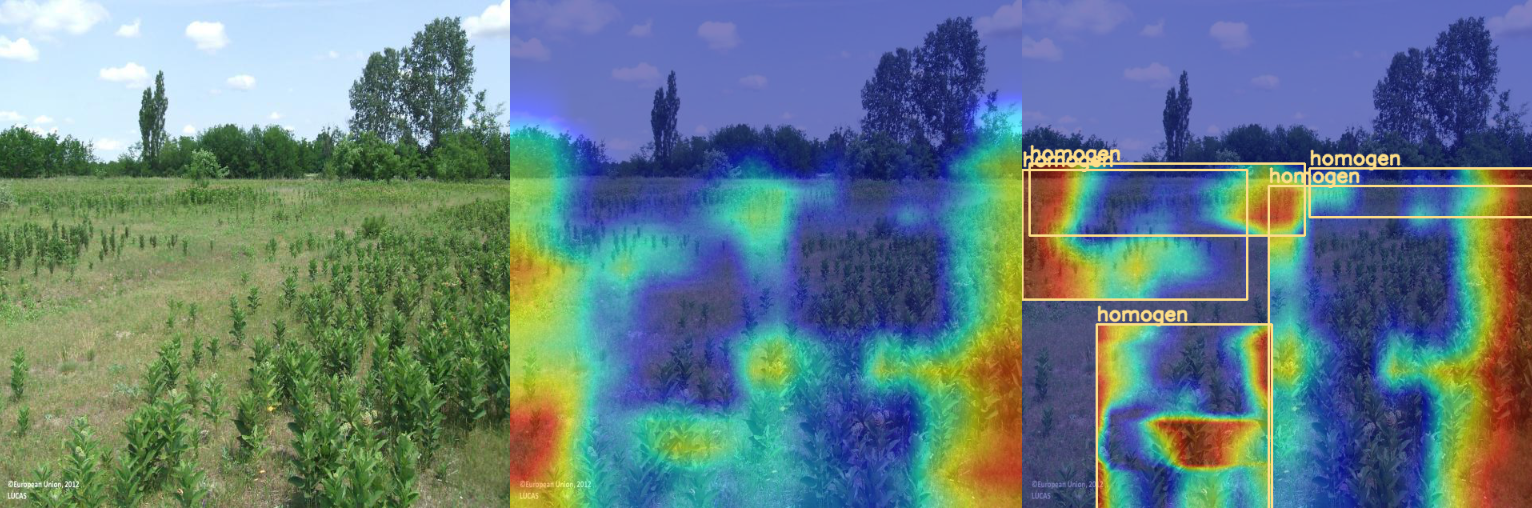

Az első (jobboldali) képen a bemenet látaható, középen a háló aktivációja és az utolsó (baloldali) képen a bounding boxon belüli aktiváció látható. Körülbelül lefedi azt a régiót, ahol a növényfaj megjelenik. Ez lenne az elvásárás, hogy azokon a képeken is, ahol nem történt detekció, de azokban az esetekben a háló aktivációja ha magas is egy helyen, a YOLO másmilyen küszöbértékeket is figyelembe vesz az objektumok felismerésében, ezért nem hagyatkozhatunk teljessen a magas aktivációs régiókra. Esetek, ahol magas az aktiváció és mégsincs objektum detektálás:

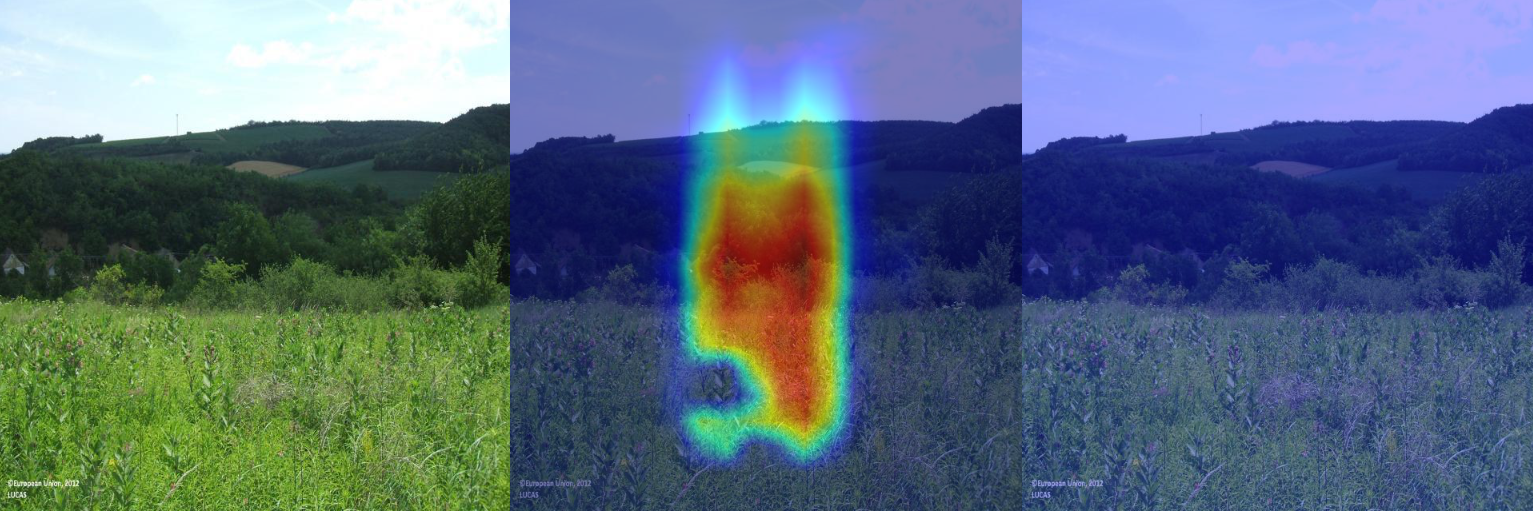

Az alábbi esetben a kép közepére esik nagy fókusz, itt részeb benne is van a selyemkóró, mégsem történik meg a felismerés, másrészt egy része az aktivációnak a fás részre esik. Ebben az esetben valószínűleg a YOLO által száolt egyéb küszöbértékek nem haladták meg az elvárt értéket és ezért nem ismerte fel a növényt.

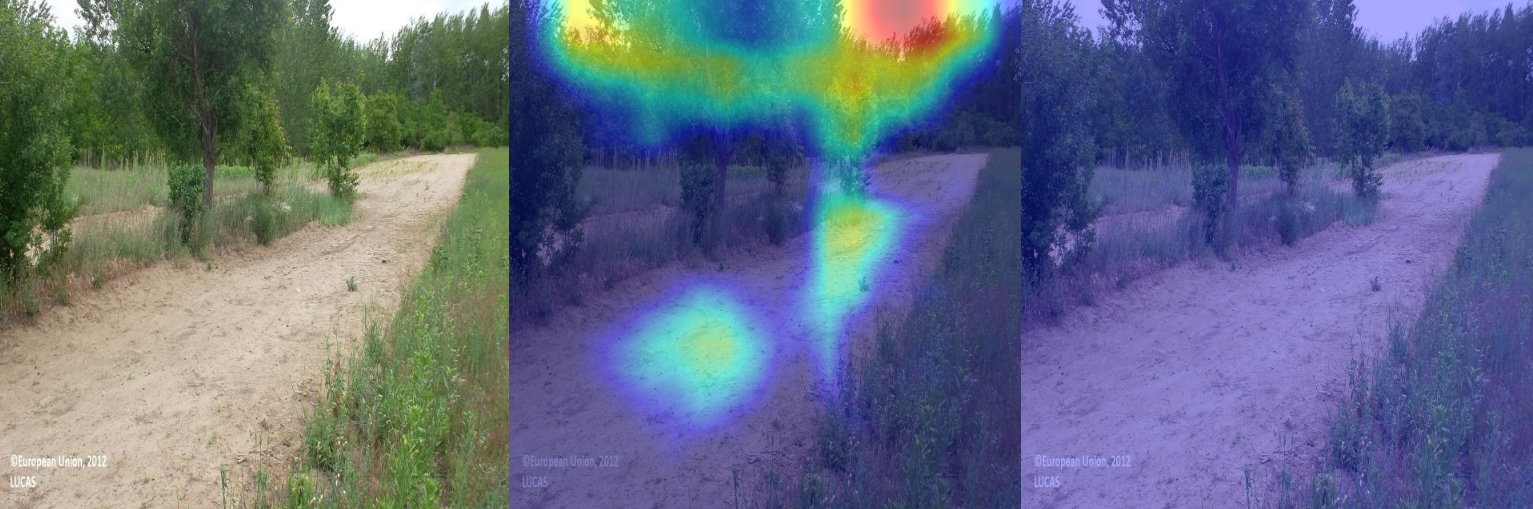

Az alábbi képen a fotó jobb oldalán szerepel egy homogén terület, látni lehet, hogy a háló az égre és a fákra fektetett nagyobb hangsúlyt, ez esetben nem tudom, hogy mi lehetett a probléma, talán a tanító adatbázisban nem volt megfelelő egyed erre az adott esetre.

Az EigenCAM az objektumdetektálás tekintetében betekintést nyújt számunkra a CNN-t aktiváló régiókba, azonban ahogy ez kiderült, a YOLO nem csak az alapján hozza meg a döntést, hogy a hálót hol érte nagy behatás, hanem egyéb paramétereket vesz figyelembe, ugyebár felméri, hogy hol talál objektumokat a képen és ahol nincs objektum, ott értelemszerűen hiába magas az aktiváció, az algoritmus nem fogja figyelembe venni a döntéshozatalnál.